<div class="alert alert-block alert-success">
    <h1>DataLab HvA - serie Machine Learning Python - Tech report 10</h1>
</div>

<div class="alert alert-block alert-warning">
    <h2>Random Forest Classificatie</h2>
</div>

### 0. Doel van deze les
Vanwege de serie lessen waarbinnen deze les valt is het hierin de insteek is om het gemaakte model te gaan vergelijken met andere andere Machine Learning modellen en daarbij een kwaliteitscriterium te hanteren waarmee *alle* modellen onderling vergelijkbaar zijn. Dit is de reden dat we werken met een test- en een trainset van onze data.
**Je leert** 
- hoe je in Python met behulp van het package `sklearn` een Random Forest t.b.v. een Classificatietaak kunt maken
- (een selectie van) hyperparameters die gekozen kunnen worden om het model te optimaliseren
- hoe je dit model kunt gebruiken om voorspellingen te genereren op nieuwe data

**Je leert niet:**
- wat de preciese wiskundige definitie en werking van het algoritme is
- hoe je met het package `seaborn` eerste visuele verkenningen van de (variatie in de) data kan uitvoeren, zie hiervoor *Tech report 1: Introductie Machine Learning* uit deze serie.
- hoe je data importeert en inlaadt in de python sessie, zie hiervoor echter wel [deze instructie](https://www.youtube.com/watch?v=1oBVx7pyuXo&list=PLwkTCAI_gJjW10xaAJpdqeQx7EQgFolfG&index=10) 
- wat het preciese concept en de werking van K-fold crossvalidatie en grid search zijn, zie hiervoor *Tech report 6: K-fold crossvalidatie en grid search* uit deze serie.

**Machine Learning framework**
- Om een consistente leerlijn in de serie Machine Learning aan te houden kiezen we telkens voor een opzet waarin een inititeel model bepaald wordt o.b.v. een *deel* van de beschikbare data: de *train data*. Om het model te kunnen vergelijken met ándere modeltypen (waarbij andere algoritmen worden gebruikt) stellen we de voorspellende prestaties vast a.h.v. de nog niet gebruikte data: de *test data*. 

### 1. Laden van de benodigde packages
Packages die je zelf nog niet hebt geinstalleerd dien je vooraf in Python te installeren. 

In [1]:
# Voor de dataset en plots
import matplotlib.pyplot as plt
import seaborn as sns

# Voor het bewerken en inspecteren van de data
import pandas as pd

# Voor het afsplitsen van een train- en test dataset
from sklearn.model_selection import train_test_split

# Voor het modelleren
from sklearn.ensemble import RandomForestClassifier


### 2. Laden en prepareren van de data

We gebruiken als voorbeeld een dataset `'diamonds'`. Het betreft data van verschillende kenmerken uit een grote verzameling waarnemingen van diamanten. Eén van de kenmerken is de kwaliteit van het het slijpen (`cut`). Deze kwaliteit zal onder andere mogelijk samenhangen met andere kenmerken, zoals prijs, uitgedrukt in het aantal *US dollars* (`price`), de afmetingen (`x`, `y` en `z`), het gewicht (`carat`), de kleur (`color`) en de helderheid (`clarity`). Lees meer over deze dataset in de link [hier](https://ggplot2.tidyverse.org/reference/diamonds.html), daar worden ook de variabelen `table` en `depth` toegelicht en lees je dat voor `cut` de volgende waarden gedefinieerd zijn: `Fair`, `Good`, `Very Good`, `Premium`, `Ideal`.

#### Laden en weergave data
Zie de code hieronder voor het laden van de data. Er zijn geen missende waarden aanwezig (inspecteer dit ook zélf!) - zie *TR2 - Datapreparatie*  uit deze serie. 

In [2]:
# Laden van een standaard dataset uit package seaborn 
data = sns.load_dataset('diamonds')
print(data.head())
print(data.shape)
print(data.dtypes)

   carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75
(53940, 10)
carat       float64
cut        category
color      category
clarity    category
depth       float64
table       float64
price         int64
x           float64
y           float64
z           float64
dtype: object


#### One-Hot encoding categoriale variabelen
We zien dat we te maken hebben met drie categoriale variabelen (`cut`, `color` en `clarity`), waarvan de *eerste* onze te voorspellen variabele (`y`) zal worden. Het random forest kan met *de andere twee* categoriale variabelen in de *X-data* niet overweg. We maken hiervoor *one-hot encoded variabelen* aan, voor iedere waarde van de categoriale variabelen één (`drop_first=False`) :

In [3]:
data = pd.get_dummies(data=data, columns= ['color', 'clarity'], drop_first=False)
print(data.head())
print(data.shape)
print(data.dtypes)

   carat      cut  depth  table  price     x     y     z  color_D  color_E  \
0   0.23    Ideal   61.5   55.0    326  3.95  3.98  2.43        0        1   
1   0.21  Premium   59.8   61.0    326  3.89  3.84  2.31        0        1   
2   0.23     Good   56.9   65.0    327  4.05  4.07  2.31        0        1   
3   0.29  Premium   62.4   58.0    334  4.20  4.23  2.63        0        0   
4   0.31     Good   63.3   58.0    335  4.34  4.35  2.75        0        0   

   ...  color_I  color_J  clarity_IF  clarity_VVS1  clarity_VVS2  clarity_VS1  \
0  ...        0        0           0             0             0            0   
1  ...        0        0           0             0             0            0   
2  ...        0        0           0             0             0            1   
3  ...        1        0           0             0             0            0   
4  ...        0        1           0             0             0            0   

   clarity_VS2  clarity_SI1  clarity_SI2  cl

#### Split variabelen X en y
In dit voorbeeld willen we de waarde voor `cut` gaan voorspellen, zie ook *sectie 3: Voorbeschouwing* verderop.

In [4]:
#independent variables / explanatory variables
X = data.drop('cut', axis=1)

#dependent variable / response / target variable.
y = data['cut']

In [5]:
#type(y) #pandas.core.series.Series
#type(X) #pandas.core.frame.DataFrame

#### Afsplitsen test data en train data
Voor meer details over deze stap, zie *Tech report 2: Datapreparatie* uit deze serie.

In [6]:
# Split in training en test data 
# random_state kiezen zorgt voor reproduceerbaarheid van dit resultaat - gebruik dat ! Een andere waarde is uiteraard ook prima
# we kiezen voor een verhouden train - test van 75% - 25%. Andere keuzen kunnen ook!
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.25,random_state=999)
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(40455, 22)
(13485, 22)
(40455,)
(13485,)


### 3. Voorbeschouwing
Zomaar modelleren doe je niet, eerst moeten we vaststellen wat we willen bereiken of welke vraag we zouden willen beantwoorden. Voor deze les zal dat worden:
- Taak: stel een random forest classificatiemodel op om de kwaliteit van het slijpen van de diamant zo goed mogelijk te voorspellen op basis van de overige variabelen 

Vanuit de taak zullen we dus stellen:
- De *onafhankelijke* variabelen ($x_i$) zijn de variabelen `carat`, `price`, `color_[7x]`, `clarity_[8x]`, `depth`, `table`, `x`, `y`, en `z`.
- De *afhankelijke* variabele ($y$) is de variabele `cut`

#### Random Forest
Een random forest model is een vorm van *ensemble learning*, waarbij uit wordt gegaan van het volgende inzicht:

- Als je meerdere slechte modellen hebt, dan:
    - Zal ieder model overfit zijn op een gedeelte van de data.
    - Zal ieder model een grote fout (hoge variantie) hebben.
- Maar als je een nieuw model maakt door de resultaten van andere modellen te middelen, dan:
    - Zal dit nieuwe model minder overfit zijn.
    - Zal dit nieuwe model een lagere variantie hebben.
    
Een random forest bestaat uit een aantal (default: `n_estimators = 100`) verschillende regressiebomen, waarvan een voorspelling zal bestaan uit het gemiddelde van alle voorspelde waarden van al deze bomen afzonderlijk (*aggregation*). Alle mogelijke *hyperparameters* voor deze bomen zijn daarom ook in het random forest beschikbaar, zoals bijvoorbeeld: `max_depth`, `ccp_alpha` en `criterion`, die ook worden besproken in *TR 8 - Beslisbomen* in deze serie. 

Om ervoor te zorgen dat we **niet** telkens *dezelfde boom* schatten

- wordt iedere boom gefit op een random steekproef, met teruglegging, (een bag) van de data (dit wordt *bagging* of *bootstrapping* genoemd); dit heeft als bijkomend voordeel dat het deel dat niet gebruikt wordt als validatieset kan worden gebruikt (*Out Of Bag - OOB*) (hyperparameter `bootstrap = True` (default)). Lees hierover meer in sectie 6 verderderop.   
- kan ook het *aantal samples* aan data dat voor het trainen van iedere boom afzonderlijk wordt gebruikt worden gereguleerd: 
    - evenveel als het aantal samples dat de traindata in totaal bevat: `max_samples = None`(default). NB: bedenk dat random sampling *met teruglegging* ervoor zorgt dat je dan tóch steeds een andere trainingset per boom zal gebruiken  
    - het is ook in te stellen als een percentage van het aantal traindata samples of een absoluut aantal  
- is het een optie ervoor te kiezen dat bij iedere split er slechts gekozen mag worden uit een random selectie van de verklarende variabelen $X_1$ t/m $X_p$. (NB: onderstaande hyperparameter was óók al tekiezen bij de beslisboom)
    - De hyperparameter `max_features = 1.0` (default) zal default zo staan ingesteld dat *alle* variabelen bij een split in aanmerking kunnen worden genomen.   
    - Een veelvoorkomende keuze is om de optie `max_features = 'sqrt'` te kiezen, dan wordt er steeds een random set van (afgerond) de wortel van het totaal aantal variabelen beschikbaar gesteld om tot de *beste split* te komen. Andere opties zijn ook beschikbaar. 

Ga na dat wanneer we `max_features` aanpassen t.o.v. de default, er *twee* random elementen per boom aanwezig zijn in dit proces, dit zorgt voor een forest met allemaal verschillende bomen. 

### 4. Model schatten
#### lees documentatie bij package
Voordat we een model gaan schatten is het van belang dat je de documentatie van het algoritme dat we uit het package gaan gebruiken lezen. In dit geval is dat dus voor `RandomForestClassifier()`, die lees je bijvoorbeeld online [hier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). Alternatief is om de `help()` functie te gebruiken, zie hieronder. 

In [7]:
# We gaan de methode RandomForestClassifier() uit het sklearn package gebruiken, inspecteer hiervoor de documentatie. Dat kan 
help(RandomForestClassifier())

Help on RandomForestClassifier in module sklearn.ensemble._forest object:

class RandomForestClassifier(ForestClassifier)
 |  RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
 |  
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and uses averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is controlled with the `max_samples` parameter if
 |  `bootstrap=True` (default), otherwise the whole dataset is used to build
 |  each tree.
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  Parameters
 |  ----------

Zie bijvoorbeeld de parameters die we ook zien bij enkele regressiebomen: `criterion`, `max_depth`, en `ccp_alpha`, maar daarnaast dus zoals ook al eerder genoemde `n_estimators`, `bootstrap` en `max_samples` en bijvoorbeeld ook een parameter die het evalueren van de *Out Of Bag score* gedurende het trainen kan activeren: `oob_score`.  Ook lees je dat er een *method*  `fit()` voor deze *object class* gedefinieerd is om het model te *fitten*.

#### model fitten
We gebruiken dus de train data om een model te fitten. Dit is, zoals je ziet, een eenvoudig regeltje code. We geven het model een naam (`rfc`) zodat we het later weer opnieuw kunnen aanroepen / gebruiken.

In [8]:
# Met model fitten default van package
rfc = RandomForestClassifier(random_state = 9, oob_score = True) #oob_score = True met oog op sectie 7
#Fit the regressor object to the dataset.
rfc.fit(train_X,train_y)

RandomForestClassifier(oob_score=True, random_state=9)

### 5. Model weergeven
Het weergeven van (kenmerken van) een random forest classifier is visueel gezien lastig. Zoals een paar cellen hieronder te zien is (of te lezen is in de boven getoonde help-functie van `RandomForestClassifier()`) hebben we te maken met de defaultwaarde `'n_estimators': 100` regressiebomen. We kunnen wel de *feature importance* weergeven, lees hierover meer op [deze pagina](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.feature_importances_). We tonen meteen een handige visualisatie:

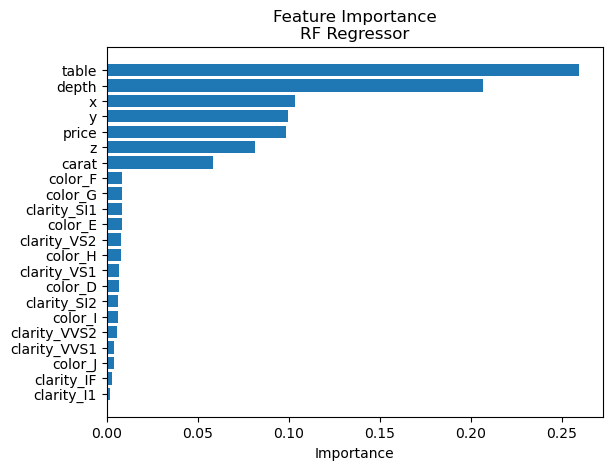

In [9]:
imp_data = pd.DataFrame({'Name':rfc.feature_names_in_, 'Importance':rfc.feature_importances_})
imp_data = imp_data.sort_values(by='Importance', ascending=True)
plt.barh(range(rfc.n_features_in_), imp_data['Importance'])
plt.yticks(range(rfc.n_features_in_),imp_data['Name'].to_numpy())
plt.xlabel('Importance')
plt.title('Feature Importance\nRF Regressor')
plt.show()

Het lijkt erop dat `table` en `depth` de meest belangrijke variabelen zijn om een split op te maken voor deze classificatietaak. 

De gebruikte parameters in de aanroep (nu dus cf. de defaults, m.u.v. `random_state` en `oob_score`):

In [10]:
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': True,
 'random_state': 9,
 'verbose': 0,
 'warm_start': False}

Het type model in het ensemble (bos):

In [11]:
rfc.estimator

DecisionTreeClassifier()

### 6. OOB-score
Zoals in sectie 3 - Voorbeschouwing - al werd vermeld is er per boom in de Random Forest een set trainings samples die *niet* werd betrokken bij de training van die specifieke boom. Deze set (per boom dus anders) zijn de *Out of Bag* samples. We kunnen bij de training van het model nagaan wat de (gemiddelde) grootte van de modelscore (bijvoorbeeld de *accuracy*) is naarmate het bos aanwast met meer bomen. Bedenk dat *alle bomen samen* als modeloutput, via middeling, de voorspelde waarde teruggeven. Dit is de *OOB-score* (of *OOB-error*) van het random forest. 

#### Aantal variabelen per split en aantal bomen in het bos
Een belangrijke parameterkeuze voor een random forest is de eerder genoemde `max_features` (het aantal variabelen dat wordt betrokken in de vaststelling van *de beste split* in iedere beslisboom). Default is de waarde `max_features = 1.0` (*alle variabelen*), maar als er bijvoorbeeld een grote correlatie tussen één of meerdere variabelen is, werkt het beter om *minder* variabelen in de split te betrekken. We zouden graag een idee van het effect hiervan willen hebben bij onze data.  

Een andere variabele die de moeite van het zorgvuldig kiezen waard is, is het aantal bomen in het bos: `n_estimators`(default `n_estimators = 100`). Ga na dat het voor de uiteindelijke modelprestaties niet uitmaakt als je er *te veel* opneemt, alleen wel voor de trainingstijd natuurlijk en de omvang van het model qua opslag op je computer. We zouden een idee willen hebben van wanneer het bos groot genoeg is. 

Een veel gehanteerde wijze om bovenstaande parameters te kiezen, waarbij rekening wordt gehouden met onderlinge samenhang, is het plotten van de *OOB-score* gedurende het trainingsproces naarmate het aantal bomen toeneemt (tot maximaal de gekozen waarde van `n_estimators`). Dit kan het beste grafisch worden weergegeven, hiervan wordt hieronder een codevoorbeeld gegeven dat is gebaseerd op het voorbeeld [hier](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html). 

Een parameter die hierbij nog interessant is om in overweging te nemen is `max_samples`, dat is het *aantal samples* dat met teruglegging (random) wordt gesampled uit de gehele traindataset bij het vaststellen van de *Bag* die per boom wordt gekozen. (default `max_samples = None`, dat betekent: evenveel als het complete aantal samples in de traindataset). Des te *groter* die is, des te *kleiner* is de set *Out of Bag* samples. We gaan hier verderop wat dieper op in, die subsectie kan ook overgeslagen worden.

Lees zélf in de documentatie (output helpfunctie hierboven) wat de betekenis is van de `score` die hier wordt bepaald!

C:\Users\kesjs\Anaconda3\envs\datalab\lib\site-packages\sklearn\ensemble\_forest.py:584: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\kesjs\Anaconda3\envs\datalab\lib\site-packages\sklearn\ensemble\_forest.py:584: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\kesjs\Anaconda3\envs\datalab\lib\site-packages\sklearn\ensemble\_forest.py:584: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\kesjs\Anaconda3\envs\datalab\lib\site-packages\sklearn\ensemble\_forest.py:584: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\kesjs\Anaconda3\envs\datalab\lib\site-packages\sklearn\ensemble\_forest.py:

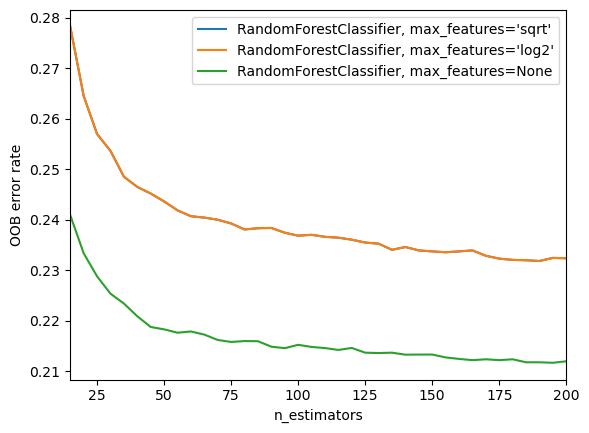

In [12]:
RANDOM_STATE = 9 #Uiteraard aanpasbaar

ensemble_clfs = [
    (
        "RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(
            warm_start=True,  #Om niet bij toevoeging van een extra boom in de for-loop onder het complete bos opnieuw te schatten!
            oob_score=True,   #We willen deze beschikbaar hebben
            max_features="sqrt", #Dit is onze variatie per model
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_features="log2",
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_features=None",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_features=None,
            random_state=RANDOM_STATE,
        ),
    ),
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
from collections import OrderedDict
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 200

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 5):
        clf.set_params(n_estimators=i)
        clf.fit(train_X,train_y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [13]:
# De max_features='sqrt' en max_features='log2' geven exact dezelfde score
print("max_features='sqrt': \n", error_rate["RandomForestClassifier, max_features='sqrt'"][:9], "\n")
print("max_features='log2': \n", error_rate["RandomForestClassifier, max_features='log2'"][:9])

max_features='sqrt': 
 [(15, 0.2782350760103819), (20, 0.2645161290322581), (25, 0.25697688790013595), (30, 0.253639846743295), (35, 0.24852305030280564), (40, 0.24649610678531697), (45, 0.24518600914596467), (50, 0.24362872327277219), (55, 0.2418489679891237)] 

max_features='log2': 
 [(15, 0.2782350760103819), (20, 0.2645161290322581), (25, 0.25697688790013595), (30, 0.253639846743295), (35, 0.24852305030280564), (40, 0.24649610678531697), (45, 0.24518600914596467), (50, 0.24362872327277219), (55, 0.2418489679891237)]


Wat we hier bijvoorbeeld zien is   
1. dat de error rate na ongeveer 200 bomen stabiliseert (méér heeft dus geen zin)
2. de error bij alle variabelen per split (`max_features=None`, oftewel de default waarde `1.0`) het laagst is
3. de error voor `max_features='sqrt'` en `max_features='log2'` identiek zijn (de plots vallen over elkaar heen)  

Aan de lezer om na te gaan dat het hanteren van een kleinere waarde voor `max_samples` niet tot een ander inzicht zal leiden, hieraan gekoppeld is ook de (facultatieve) sectie hieronder. 

#### Omvang Out of Bag set
De vraag zou kunnen opkomen of de *Out of Bag* set wel groot genoeg is om als betrouwbare validatie dataset te dienen? Hier volgt een korte analyse hierop.

Algemeen: we starten met een complete traindataset van $N$ samples trekken daar *met teruglegging* $N$ samples uit voor onze *Bag* die we voor een specifieke boom uit het bos gaan gebruiken. Eenzelfde sample kan dus **meerdere malen** in de *Bag* voorkomen(!). Wat is de kans dat een specifiek sample $S_i$ *helemaal niet wordt gekozen* in de *Bag*? Ga na dat die gelijk is aan:  

$$p = \mathbb{P}(S_i \notin Bag) = (1-\frac{1}{N})^N \qquad for \quad i = 1\ldots N $$  

Definiëer vervolgens de kansvariabele $OOB$ als het *aantal samples* dat *niet* in de *Bag* gekozen is:  

$$OOB := \Sigma_{i = 1}^{N} 1_{\{S_i \notin Bag\}})$$ 

met $1_{\{S_i \notin Bag\}} := 1$ als sample $S_i$ *niet* in de *Bag* terecht is gekomen en $1_{\{S_i \notin Bag\}} := 0$ als sample $S_i$ minstens eenmaal in de *Bag* terecht is gekomen.

Dan is $OOB \sim Bin(N,p)$ en $\mathbb{E}[OOB] = N \cdot p$

Met de gegevens uit ons voorbeeld:

In [14]:
import numpy as np
print("Het aantal samples in de complete traindataset: N = ", train_X.shape[0])
print("de kans dat een sample niet in de Bag ter grootte N komt, p=", np.around((1-1/train_X.shape[0])**train_X.shape[0],3))
print("het verwacht aantal OOB-samples E[OOB] = ", int(np.floor(train_X.shape[0]*(1-1/train_X.shape[0])**train_X.shape[0])))

Het aantal samples in de complete traindataset: N =  40455
de kans dat een sample niet in de Bag ter grootte N komt, p= 0.368
het verwacht aantal OOB-samples E[OOB] =  14882


In het algemeen geldt:
$$p(N) := (1-\frac{1}{N})^N \quad en \quad  \lim_{N\to\infty} p(N) = \lim_{N\to\infty} (1-\frac{1}{N})^N = \frac{1}{e} \approx 0.368$$

Met andere woorden, bij grote traindatasets zal per getrainde boom rond de 37% van de samples in de OOB-score betrokken zijn. indien we steeds `N` samples gebruiken in de trainfase per boom (`max_samples = None`). 

### 7. Tuning hyperparameters - MEE VERDER!

<div class="alert alert-block alert-danger">
    <h2>Hoe divesre scores op OOB data vaststellen??</h2>
    Kan het uberhaupt?
</div>

#### OOB vs Train resultaten
Hieronder vergelijken we de prestaties op OOB-sets met die op de traindataset. Lees zélf in de documentatie (output helpfunctie hierboven) wat de betekenis is van de `score` die hier wordt bepaald!

In [15]:
predicted_y_tr = rfc.predict(train_X)
print("OOB-score initiele model = ", rfc.oob_score_)
print("Model-score initiele model op traindata = ", rfc.score(train_X, predicted_y_tr))

OOB-score initiele model =  0.7631689531578297
Model-score initiele model op traindata =  1.0


We kunnen ook een andere metric kiezen, start met de oob-voorspellingen (`rfc.oob_decision_function_`) van het (kans)model:

In [54]:
print(pd.DataFrame(rfc.oob_decision_function_, columns = rfc.classes_))

           Fair      Good     Ideal   Premium  Very Good
0      0.000000  0.000000  0.055556  0.861111   0.083333
1      0.000000  0.000000  0.655172  0.137931   0.206897
2      0.000000  0.000000  0.073171  0.804878   0.121951
3      0.024390  0.195122  0.048780  0.365854   0.365854
4      0.000000  0.027778  0.666667  0.138889   0.166667
...         ...       ...       ...       ...        ...
40450  0.026316  0.631579  0.026316  0.078947   0.236842
40451  0.000000  0.000000  0.135135  0.567568   0.297297
40452  0.000000  0.000000  1.000000  0.000000   0.000000
40453  0.000000  0.000000  0.000000  0.976744   0.023256
40454  0.000000  0.000000  0.023810  0.714286   0.261905

[40455 rows x 5 columns]


In [119]:
# De classificatie wordt dan als volgt naar de klassen 0, 1, 2, 3 en 4 
# die corresponderen met de resp. 5 klassen 'Fair' 'Good' 'Ideal' 'Premium' 'Very Good' van variabele `cut`:
pred_oob = np.argmax(rfc.oob_decision_function_,axis=1)
print(pred_oob)

[3 2 3 ... 2 3 3]


In [120]:
# Als we dit willen terugvertalen naar de originele klasselabels dan kan dat als volgt:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(rfc.classes_) #de encoder kent nu de link tussen klassenummer en klassenaam

# Van klassenummer naar klassenaam:
pred_oob = le.inverse_transform(pred_oob)
print(pred_oob)

['Premium' 'Ideal' 'Premium' ... 'Ideal' 'Premium' 'Premium']


Nu kun je diverse scores berekenen, zoals de accuracy (die ook als default werd bepaald in de reguliere `score()` methode bij dit model:

In [121]:
from sklearn import metrics

#Accuracy train
print("De accuracy op de trainset = ", metrics.accuracy_score(train_y, predicted_y_tr))
#Accuracy OOB
print("De accuracy op de OOB-sets = ", metrics.accuracy_score(train_y, pred_oob))
#rfr.oob_prediction_

De accuracy op de trainset =  0.9998764058830799
De accuracy op de OOB-sets =  0.7631689531578297


Maar ook een (multi-class variant van) de Confusion Matrix kan:

In [127]:
#Confusion Matrix train
print("De Confusion Matrix op de trainset : \n", metrics.confusion_matrix(train_y, predicted_y_tr))
#Confusion Matrix OOB
print("De Confusion Matrix op de OOB-sets : \n", metrics.confusion_matrix(train_y, pred_oob))
#rfr.oob_prediction_

De Confusion Matrix op de trainset : 
 [[ 1177     0     0     0     0]
 [    0  3685     0     0     0]
 [    0     0 16170     0     0]
 [    0     0     1 10331     0]
 [    0     0     0     4  9087]]
De Confusion Matrix op de OOB-sets : 
 [[  948   149    13    34    33]
 [   92  2468    71   229   825]
 [    9    24 14835   681   621]
 [    0    50  1138  8301   843]
 [    5   586  2035  2143  4322]]


Het model is zo lang doorgegaan met het maken van vertakkingen tot de scoremaat niet meer beter werd op de traindataset...er is hierdoor wel duidelijk sprake van overfitting: op de OOB-set (functioneert als validatieset) presteert het model aanmerkelijk minder goed. 

#### hyperparameters
Om dit te verbeteren zullen we moeten zoeken naar een betere samenstelling van de hyperparameters in de training van het model. We hebben ons random forest uit het voorbeeld in sectie 4 hierboven zónder enige restrictie gefit. Zoals te zien in de documentatie (via `help(RandomForestRegressor())`) zijn er flink wat hyperparameters om de te kiezen. Het is mogelijk dit via een *grid search* te doen, lees hierover meer in *Tech report 6 K-fold crossvalidatie en Grid Search* uit deze serie. Een **nadeel** hiervan is dat het aantal modellen dat moeten worden vergeleken vanwege het hoge aantal parametercombinaties heel groot kan worden en de doorlooptijd van een gridsearch (met ook nog de gebruikelijke werkwijze via een k-fold Cross Validatie) **heel lang** kan duren. Houd hier rekening mee.

Via de OOB-score hebben we met betrekking tot `max_features` en `n_estimators` zoals in sectie 6 werd besproken wel een indruk m.b.t. de ligging van de beste parameterwaarden gekregen. 

Ten slotte kan worden opgemerkt dat veel van de *default parameterwaarden* door de bouwers van het package al zodanig gekozen zijn dat ze initieel al behoorlijk goede resultaten zullen geven in de meest gangbare gevallen.

### 7. Trainen model met optimale parameterwaarden
Op het moment dat je een geoptimaliseerde parameterset hebt gevonden train je het model met *deze parameters* nogmaals op de hele traindataset (*from scratch*). 

In [ ]:
#Definitie
rfc_opt = RandomForestClassifier(...) # op ... de samenstelling van de optimale parameterwaardenset
#fitten
rfc_opt.fit(train_X,train_y)


We maken voorspelling op de train data en evalueren deze:

In [ ]:
predicted_y_tr = rfr_opt.predict(train_X)
from sklearn import metrics

#Accuracy op train
print("De accuracy op de trainset = ", metrics.accuracy_score(train_y, predicted_y_tr))

### 7. Voorspellingen en perfomance op testset
Ten slotte genereren we de voorspellingen van y op de testset. Tevens produceren we een modelscore. Voor meer toelichting daarover verwijzen we naar *Tech report 3: performance metrics regressie en classificatie*.

In [ ]:
predicted_y = rfc_opt.predict(test_X)

#Accuracy op train
print("De accuracy op de testset = ", metrics.accuracy_score(test_y, predicted_y))